In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import pickle
import sys
import pandas as pd

In [172]:
def reconstruct_density_matrix(expectation):
    """
    Reconstruct a 2×2 density matrix ρ from Bloch-vector expectations.
    
    ρ = ½ (I + ex·σx + ey·σy + ez·σz)
    
    Args:
      expectation: sequence or list [ex, ey, ez]
    Returns:
      2×2 complex ndarray ρ
    """
    ex, ey, ez = expectation
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    return 0.5 * (I + ex*sigma_x + ey*sigma_y + ez*sigma_z)

def nearest_pure_state(rho):
    """
    Find the pure state closest to ρ by taking the eigenvector 
    of ρ with the largest eigenvalue.
    
    Args:
      rho: 2×2 Hermitian density matrix
    Returns:
      lam_max:    largest eigenvalue (float)
      psi:        corresponding normalized eigenvector (length-2 complex array)
      rho_pure:   pure-state density matrix |ψ⟩⟨ψ|
    """
    eigvals, eigvecs = np.linalg.eigh(rho)
    idx = np.argmax(eigvals)
    lam_max = eigvals[idx]
    psi = eigvecs[:, idx]
    #(Optional) remove global phase so ψ[0] is real:
    # psi *= np.exp(-1j * np.angle(psi[0]))
    rho_pure = np.outer(psi, np.conj(psi))
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    exp_x_value = np.trace(rho_pure.dot(sigma_x)).real
    exp_y_value = np.trace(rho_pure.dot(sigma_y)).real
    exp_z_value = np.trace(rho_pure.dot(sigma_z)).real

    return lam_max, psi, rho_pure,exp_x_value, exp_y_value, exp_z_value

def time_series_reconstruction(xs, ys, zs):
    T = len(xs)
    rhos    = np.zeros((T,2,2), dtype=complex)
    eigvals = np.zeros(T)
    exp_x_pure   = np.zeros(T)
    exp_y_pure   = np.zeros(T)
    exp_z_pure   = np.zeros(T)
    psis    = np.zeros((T,2),   dtype=complex)
    rhos_p  = np.zeros((T,2,2), dtype=complex)

    for t, (ex, ey, ez) in enumerate(zip(xs, ys, zs)):
        # 1) reconstruct ρ and find raw eigenvector
        rho       = reconstruct_density_matrix([ex, ey, ez])
        lam, psi_raw, rho_p,exp_value_x,exp_value_y,exp_value_z = nearest_pure_state(rho)
        rhos[t]      = rho
        eigvals[t]   = lam
        psis[t]      = psi_raw
        rhos_p[t]    = rho_p
        exp_x_pure[t]     = exp_value_x
        exp_y_pure[t]     = exp_value_y
        exp_z_pure[t]     = exp_value_z

    return rhos, eigvals, psis, rhos_p, exp_x_pure, exp_y_pure, exp_z_pure

def load_and_reconstruct(initial_state, r,
                         folder="non_hermition_simulation"):
    """
    Load exp_x, exp_y, exp_z for the given initial_state,
    run time_series_reconstruction(), and return:

      {
        "rhos":    rhos,    # mixed-state density matrices ρ(t)
        "eigvals": eigvals, # largest eigenvalue λ_max(t)
        "psis":    psis,    # closest pure-state vectors ψ(t)
        "rhos_p":  rhos_p   # pure-state density matrices |ψ⟩⟨ψ|(t)
      }
    """
    # build the filename you used when pickling
    fname = f"Jdrive={r:.3g}J_ep_state={initial_state}.pkl"
    path = os.path.join(folder, fname)

    # load your saved expectations
    with open(path, "rb") as f:
        data = pickle.load(f)
    xs, ys, zs,rho_ef = data["exp_x"], data["exp_y"], data["exp_z"], data["rho_ef"]

    # run your existing reconstruction routine
    rhos, eigvals, psis, rhos_p,exp_x_pure,exp_y_pure,exp_z_pure = time_series_reconstruction(xs, ys, zs)

    return {
        "rhos":    rhos,
        "eigvals": eigvals,
        "psis":    psis,
        "rhos_p":  rhos_p,
        "rho_ef": rho_ef,
        "exp_x_pure": exp_x_pure,
        "exp_y_pure": exp_y_pure,
        "exp_z_pure": exp_z_pure
    }

def load_and_reconstruct_from_experiment(csv_filename):
    """
    Load a tomography CSV and reconstruct the two-level state trajectory.

    Args:
      csv_filename: path to CSV with columns
                    ["time", "P_f_tomo_z", "P_f_tomo_x", "P_f_tomo_y"]

    Returns:
      dict with keys:
        "time":   1D array of time stamps
        "exp_x":  ⟨σₓ⟩ time series
        "exp_y":  ⟨σᵧ⟩ time series
        "exp_z":  ⟨σ_z⟩ time series
        "rhos":    array (T,2,2) of reconstructed mixed‐state density matrices
        "eigvals": array (T,)   of largest eigenvalues
        "psis":    array (T,2)  of closest pure‐state vectors
        "rhos_p":  array (T,2,2) of pure‐state density matrices
    """
    # 1) load the CSV
    df = pd.read_csv(csv_filename)
    time = df["time"].to_numpy()

    # 2) convert P_f → expectation:
    #    ⟨σ⟩ = P_e - P_f = (1 - P_f) - P_f = 1 - 2 P_f
    exp_z = 1 - 2 * df["P_f_tomo_z"].to_numpy()
    exp_x = 1 - 2 * df["P_f_tomo_y"].to_numpy()
    exp_y = 1 - 2 * df["P_f_tomo_x"].to_numpy()

    # 3) reconstruct the state trajectory
    rhos, eigvals, psis, rhos_p,exp_x_pure,exp_y_pure,exp_z_pure = time_series_reconstruction(exp_x, exp_y, exp_z)

    return {
        "time":    time,
        "exp_x":   exp_x,
        "exp_y":   exp_y,
        "exp_z":   exp_z,
        "rhos":    rhos,
        "eigvals": eigvals,
        "psis":    psis,
        "rhos_p":  rhos_p,
        "exp_x_pure": exp_x_pure,
        "exp_y_pure": exp_y_pure,
        "exp_z_pure": exp_z_pure
    }


In [168]:
def build_phi_filtered(psi_e, psi_f, time,state: str):
    """
    1) Compute φ_t and F_t on the full dataset of length T.
    2) Drop all t with F_t < 0.94 → idx1
    3) Re-build φ / F on that reduced subset
    4) Drop all of those with F < 0.90 → idx2
    Returns:
      time2:   np.ndarray of surviving times
      phi2:    np.ndarray shape (N2,2) of surviving superpositions
      F2:      np.ndarray length N2 of surviving overlaps
      idx2:    tuple of original indices kept
    """
    psi_e = np.asarray(psi_e)
    psi_f = np.asarray(psi_f)

    T = psi_e.shape[0]

    # --- first pass on full data ---
    phi1 = np.zeros_like(psi_e, dtype=np.complex128)
    F1   = [1.0]

    # t=0
    raw0 = (psi_e[0] + (1j if state=="-x" else -1j)*psi_f[0]) / np.sqrt(2)
    phi1[0] = raw0 / np.linalg.norm(raw0) if np.linalg.norm(raw0) else raw0

    # t=1..T-1
    for t in range(1, T):
        prev = phi1[t-1]
        plus_raw  = (psi_e[t] + 1j*psi_f[t]) / np.sqrt(2)
        minus_raw = (psi_e[t] - 1j*psi_f[t]) / np.sqrt(2)

        # normalized candidates
        phi_p = plus_raw  / np.linalg.norm(plus_raw)  if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw) if np.linalg.norm(minus_raw) else minus_raw

        # overlaps
        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi1[t], F1_t = phi_p, F_p
        else:
            phi1[t], F1_t = phi_m, F_m

        F1.append(F1_t)

    F1 = np.array(F1)

    # first filter: keep F ≥ 0.94
    idx1 = np.where(F1 >= 0.9)[0]
    psi_e1, psi_f1, time1 = psi_e[idx1], psi_f[idx1], time[idx1]

    # --- second pass on reduced data ---
    N1 = len(idx1)
    phi2 = np.zeros((N1, psi_e.shape[1]), dtype=np.complex128)
    F2   = [1.0]

    # re-init φ at the first reduced point
    raw0 = (psi_e1[0] + (1j if state=="-x" else -1j)*psi_f1[0]) / np.sqrt(2)
    phi2[0] = raw0 / np.linalg.norm(raw0) if np.linalg.norm(raw0) else raw0

    for k in range(1, N1):
        prev = phi2[k-1]
        plus_raw  = (psi_e1[k] + 1j*psi_f1[k]) / np.sqrt(2)
        minus_raw = (psi_e1[k] - 1j*psi_f1[k]) / np.sqrt(2)

        phi_p = plus_raw  / np.linalg.norm(plus_raw)  if np.linalg.norm(plus_raw)  else plus_raw
        phi_m = minus_raw / np.linalg.norm(minus_raw) if np.linalg.norm(minus_raw) else minus_raw

        F_p = abs(np.vdot(prev, phi_p))
        F_m = abs(np.vdot(prev, phi_m))

        if F_p >= F_m:
            phi2[k], F2_t = phi_p, F_p
        else:
            phi2[k], F2_t = phi_m, F_m

        F2.append(F2_t)

    F2 = np.array(F2)

    # second filter: keep F ≥ 0.90
    idx2_rel = np.where(F2 >= 0.97)[0]
    idx2     = idx1[idx2_rel]                   # map back to original indices
    phi2_f   = phi2[idx2_rel]
    F2_f     = F2[idx2_rel]


    
    # print(F2_f )
    return phi2_f, F2_f, idx2

def compute_ofs(phi_ts, psi_x):
    """
    Args:
      phi_ts: array shape (T,2), as returned by build_phi()
      psi_x:  array shape (T,2), pure‐state vectors for initial |x>
    Returns:
      ofs: complex array shape (T,), the overlap at each t
    """

    
    
    # ⟨Φ|ψ⟩ = sum conj(phi) * psi along the second axis
    numer = np.einsum('ij,ij->i', np.conjugate(psi_x),phi_ts )
    # norm = √⟨ψ|ψ⟩  (should be 1 if psi_x was normalized)
    # norms = np.linalg.norm(psi_x, axis=1)
    return numer

In [109]:
def enforce_continuous_phase(psi_array: np.ndarray, comp: int = 1) -> np.ndarray:
    """
    Given psi_array of shape (T, 2), returns a new array psi_fixed
    where for each t:
      1) the comp-th component is made real and positive,
      2) the sign is chosen (±) to minimize the jump from psi_fixed[t-1].
    
    Args:
      psi_array: raw eigenvector series, shape (T,2), complex dtype
      comp:      which component to force real (0 or 1)
    
    Returns:
      psi_fixed: shape (T,2), smoothly phased
    """
    T, N = psi_array.shape
    psi_fixed = np.zeros_like(psi_array, dtype=complex)

    # t = 0: cancel phase of component `comp` and force it positive
    phi0 = np.angle(psi_array[0, comp])
    psi0 = psi_array[0] * np.exp(-1j * phi0)
    if np.real(psi0[comp]) < 0:
        psi0 = -psi0
    
    psi_fixed[0] = psi0

    # t = 1…T-1: cancel comp-phase, then pick sign minimizing jump
    for t in range(1, T):
        raw = psi_array[t]
        phi = np.angle(raw[comp])
        cand = raw * np.exp(-1j * phi)    # make comp real
        cand_neg = -cand                  # alternative sign

        prev = psi_fixed[t-1]
        d1 = np.linalg.norm(cand     - prev,ord=np.inf)
        d2 = np.linalg.norm(cand_neg - prev,ord=np.inf)

        psi_fixed[t] = cand if d1 < d2 else cand_neg

    return psi_fixed

In [195]:
def get_ofs_exp(J_drive:float,reps:int):
    results_plus_x_exp = load_and_reconstruct_from_experiment(f"J={J_drive:.2f}_+x_full_tomography_{reps}.csv")
    results_minus_x_exp = load_and_reconstruct_from_experiment(f"J={J_drive:.2f}_-x_full_tomography_{reps}.csv")#f"J={J_drive:.2f}_-x_full_tomography_150000.csv"
    results_e_exp = load_and_reconstruct_from_experiment(f"J={J_drive:.2f}_e_full_tomography_{reps}.csv")
    results_f_exp = load_and_reconstruct_from_experiment(f"J={J_drive:.2f}_f_full_tomography_{reps}.csv")
    # results_plus_x_exp = load_and_reconstruct_from_experiment("x_full_tomography_EP(new_x+).csv")
    # results_minus_x_exp = load_and_reconstruct_from_experiment("x_full_tomography_EP(new_x-).csv")#f"J={J_drive:.2f}_-x_full_tomography_150000.csv"
    # results_e_exp = load_and_reconstruct_from_experiment("e_full_tomography_EP(new_x).csv")
    # results_f_exp = load_and_reconstruct_from_experiment("f_full_tomography_EP(new_x).csv")
    psi_e_exp = results_e_exp["psis"]   # shape (T,2)
    psi_f_exp = results_f_exp["psis"]   # shape (T,2)
    psi_x_plus_exp = results_plus_x_exp["psis"] 
    psi_x_minus_exp = results_minus_x_exp["psis"]  # shape (T,2)
    time= results_e_exp["time"] # shape (T,)
    psi_e_exp= enforce_continuous_phase(psi_e_exp,0)
    psi_f_exp= enforce_continuous_phase(psi_f_exp,1)
    psi_x_plus_exp= enforce_continuous_phase(psi_x_plus_exp,0)
    psi_x_minus_exp= enforce_continuous_phase(psi_x_minus_exp,0)
    phi_ts_plus_exp,F_plus,idx_plus= build_phi_filtered(psi_e_exp, psi_f_exp,time,"+x")
    phi_ts_minus_exp,F_minus,idx_minus= build_phi_filtered(psi_e_exp, psi_f_exp,time,"-x")
    psi_x_plus_exp=psi_x_plus_exp[idx_plus]
    psi_x_minus_exp=psi_x_minus_exp[idx_minus]
    ofs_ts_plus_exp = compute_ofs(psi_x_plus_exp, phi_ts_plus_exp)
    # ofs_ts_plus_exp_ref = compute_ofs(phi_ts_minus_exp, psi_x_plus_exp)
    ofs_ts_minus_exp = compute_ofs(psi_x_minus_exp, phi_ts_minus_exp)
    # ofs_ts_minus_exp_ref = compute_ofs(phi_ts_plus_exp, psi_x_minus_exp)
    # ofs_ts_minus_exp_ref = compute_ofs(phi_ts_plus_exp, psi_x_minus_exp[idx_plus])
    return time, ofs_ts_plus_exp, ofs_ts_minus_exp,psi_x_plus_exp ,psi_x_minus_exp,idx_plus,idx_minus

def get_ofs_sim(r:float):
    time_sim = np.linspace(0, 8, 1002)
    results_plus_x = load_and_reconstruct("x", r)
    results_minus_x = load_and_reconstruct("-x", r)
    results_e = load_and_reconstruct("e", r)
    results_f = load_and_reconstruct("f", r)

    psi_e_sim = results_e["psis"]   # shape (T,2)
    psi_f_sim = results_f["psis"]   # shape (T,2)
    psi_x_plus = results_plus_x["psis"]   # shape (T,2)
    psi_x_minus = results_minus_x["psis"]  # shape (T,2)
    psi_e_sim= enforce_continuous_phase(psi_e_sim,0)
    psi_f_sim= enforce_continuous_phase(psi_f_sim,1)

    phi_ts_plus,_,idx_plus= build_phi_filtered(psi_e_sim, psi_f_sim,time_sim,"+x")
    phi_ts_minus,_,idx_minus= build_phi_filtered(psi_e_sim, psi_f_sim,time_sim,"-x")
    psi_x_plus=psi_x_plus[idx_plus]
    psi_x_minus=psi_x_minus[idx_minus]
    ofs_ts_plus = compute_ofs(psi_x_plus,phi_ts_plus )
    # ofs_ts_plus_ref = compute_ofs(phi_ts_minus, psi_x_plus)
    ofs_ts_minus = compute_ofs(psi_x_minus,phi_ts_minus )
    # ofs_ts_minus_ref = compute_ofs(phi_ts_plus, psi_x_minus)
    return time_sim, ofs_ts_plus, ofs_ts_minus, idx_plus, idx_minus

def get_pure_state_exp():
    plus_x_raw  = load_and_reconstruct_from_experiment("x_full_tomography_EP(new_x+).csv")
    minus_x_raw = load_and_reconstruct_from_experiment("x_full_tomography_EP(new_x-).csv")
    e_raw       = load_and_reconstruct_from_experiment("e_full_tomography_EP(new_x).csv")
    f_raw       = load_and_reconstruct_from_experiment("f_full_tomography_EP(new_x).csv")
    
    # --- Helper to turn one raw dict into a clean DataFrame ---
    def make_df(raw_dict):
       
        
        # pick out only the 1-D arrays we need
        data = {
            "time"      : np.array(raw_dict["time"]).ravel(),
            "exp_x_pure": np.array(raw_dict["exp_x_pure"]).ravel(),
            "exp_y_pure": np.array(raw_dict["exp_y_pure"]).ravel(),
            "exp_z_pure": np.array(raw_dict["exp_z_pure"]).ravel(),
        }
        return pd.DataFrame(data)
    
    # 2) build four DataFrames
    df_plus  = make_df(plus_x_raw)
    df_minus = make_df(minus_x_raw)
    df_e     = make_df(e_raw)
    df_f     = make_df(f_raw)
    
    # # 3) pickle them
    # df_plus .to_pickle(f"plus_x.pkl")
    # df_minus.to_pickle(f"minus_x.pkl")
    # df_e    .to_pickle(f"e.pkl")
    # df_f    .to_pickle(f"f.pkl")
    # print("✅ All 4 DataFrames saved.")
    
    # 4) (optional) plot each
    
    return df_plus, df_minus, df_e, df_f
def get_pure_state_sim(r:float,folder:str):
    plus_x_raw  = load_and_reconstruct("x", r,folder)
    minus_x_raw = load_and_reconstruct("-x", r,folder)
    e_raw       = load_and_reconstruct("e", r,folder)
    f_raw       = load_and_reconstruct("f", r,folder)
    
    # --- Helper to turn one raw dict into a clean DataFrame ---
    def make_df(raw_dict):

        data = {
            "exp_x_pure": np.array(raw_dict["exp_x_pure"]).ravel(),
            "exp_y_pure": np.array(raw_dict["exp_y_pure"]).ravel(),
            "exp_z_pure": np.array(raw_dict["exp_z_pure"]).ravel(),
        }
        return pd.DataFrame(data)
    
    # 2) build four DataFrames
    df_plus  = make_df(plus_x_raw)
    df_minus = make_df(minus_x_raw)
    df_e     = make_df(e_raw)
    df_f     = make_df(f_raw)
    
    # # 3) pickle them
    # df_plus .to_pickle(f"plus_x.pkl")
    # df_minus.to_pickle(f"minus_x.pkl")
    # df_e    .to_pickle(f"e.pkl")
    # df_f    .to_pickle(f"f.pkl")
    # print("✅ All 4 DataFrames saved.")
    
    # 4) (optional) plot each
    # for label, df in [("+x", df_plus), ("-x", df_minus), (" e", df_e), (" f", df_f)]:
    #     plt.figure()
    #     plt.plot(df["time"], df["exp_x_pure"], label="<x>")
    #     plt.plot(df["time"], df["exp_y_pure"], label="<y>")
    #     plt.plot(df["time"], df["exp_z_pure"], label="<z>")
    #     plt.title(f"J={J_drive:.2f}, reps={reps}, state {label}")
    #     plt.xlabel("time")
    #     plt.ylabel("⟨σ⟩")
    #     plt.legend()
    #     plt.show()
    return df_plus, df_minus, df_e, df_f


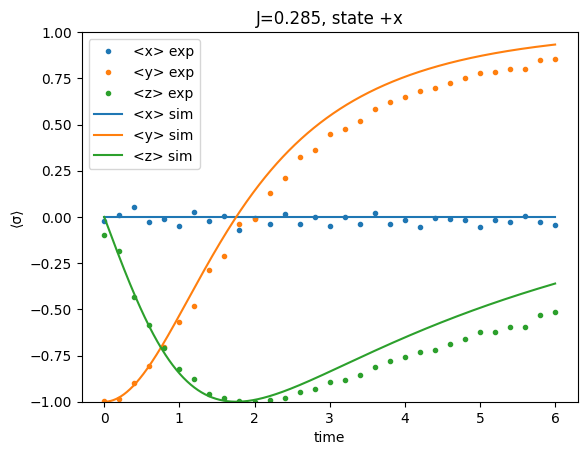

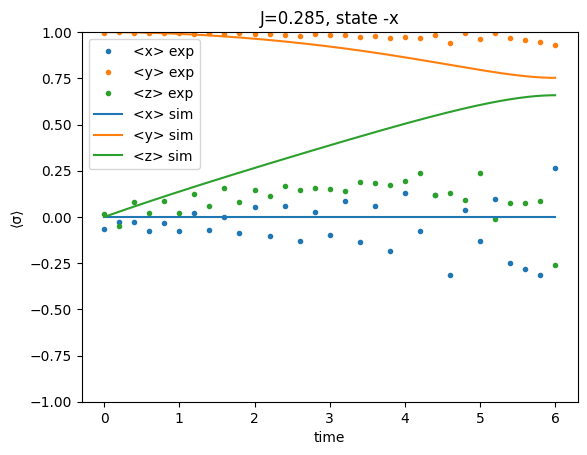

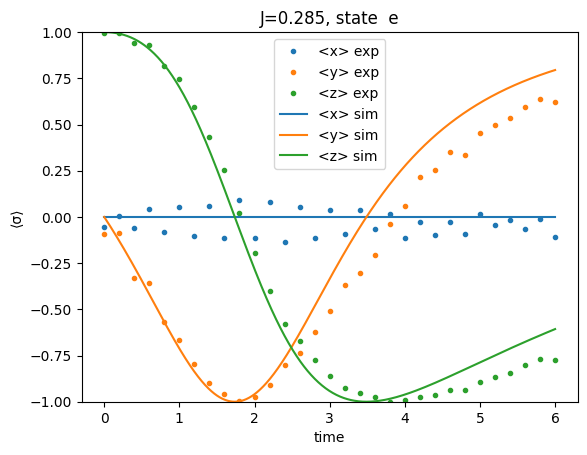

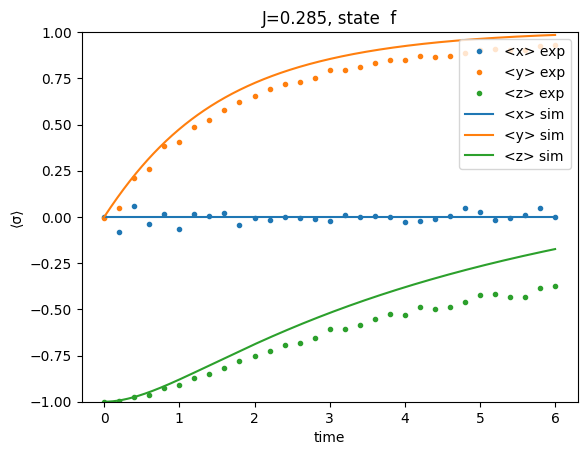

In [196]:
df_plus, df_minus, df_e, df_f= get_pure_state_exp()
df_plus_sim, df_minus_sim, df_e_sim, df_f_sim= get_pure_state_sim(1.23,"non_hermition_simulation_1.23")
time_sim = np.linspace(0, 6, 1001)
for label, df,df_sim in [("+x", df_plus,df_plus_sim), ("-x", df_minus,df_minus_sim), (" e", df_e,df_e_sim), (" f", df_f,df_f_sim)]:
        plt.figure()
        plt.plot(df["time"], df["exp_x_pure"],'C0.', label="<x> exp")
        plt.plot(df["time"], df["exp_y_pure"],'C1.', label="<y> exp")
        plt.plot(df["time"], df["exp_z_pure"],'C2.', label="<z> exp")
        plt.plot(time_sim, df_sim["exp_x_pure"],'C0', label="<x> sim")
        plt.plot(time_sim, df_sim["exp_y_pure"],'C1', label="<y> sim")
        plt.plot(time_sim, df_sim["exp_z_pure"],'C2', label="<z> sim")
        plt.title(f"J=0.285, state {label}")
        plt.ylim(-1,1)
        plt.xlabel("time")
        plt.ylabel("⟨σ⟩")
        plt.legend()
        plt.show()

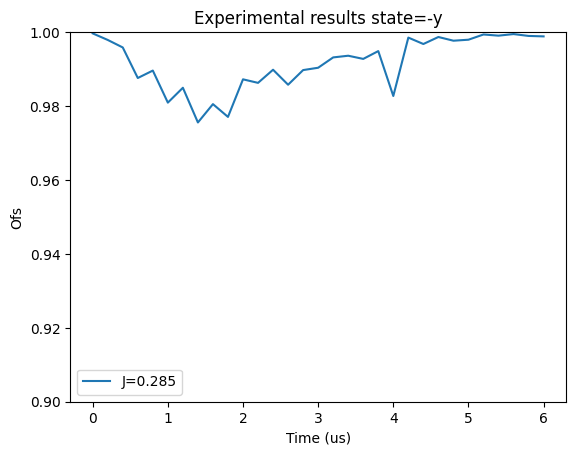

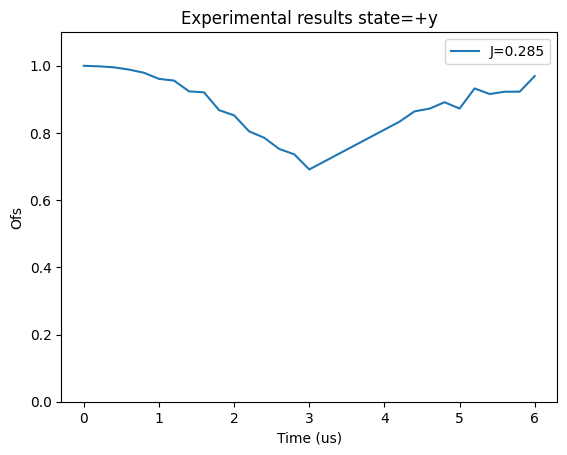

In [151]:
# time, ofs_J1_plus, ofs_J1_minus,ofs_plus_ref,ofs_ts_minus_ref,F_J1_plus,F_J1_minus= get_ofs_exp(35.7,10000)
time, ofs_J1_plus, ofs_J1_minus,ofs_plus_ref,ofs_ts_minus_ref,idx_plus,idx_minus= get_ofs_exp(35.7,10000)
# print(abs(ofs_J5_plus))

plt.plot(time[idx_plus],abs(ofs_J1_plus),label="J=0.285")


plt.ylim(0.9,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Experimental results state=-y")
plt.legend()
plt.show()

         


plt.plot(time[idx_minus],abs(ofs_J1_minus),label="J=0.285")


plt.legend()
plt.ylim(0,1.1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Experimental results state=+y")
plt.show()

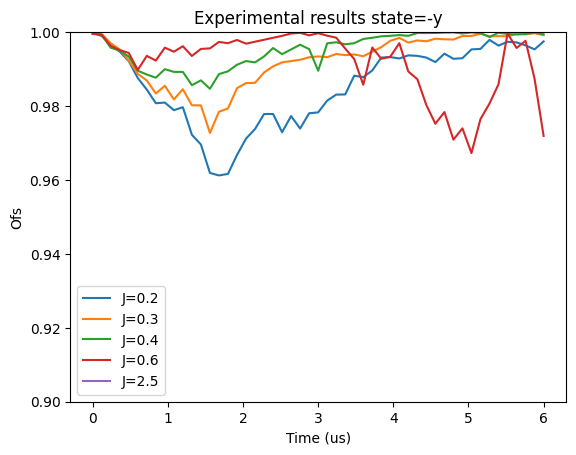

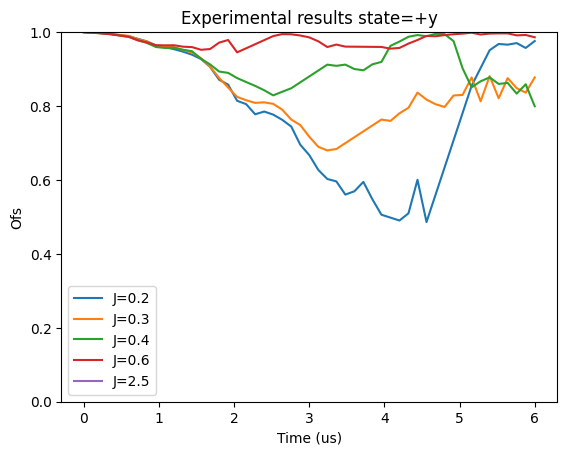

In [170]:
#+x_state=e-i*f,-x_state=e+i*f

time, ofs_J1_plus, ofs_J1_minus,_,_,idx_J1_plus,idx_J1_minus= get_ofs_exp(0.2,40000)
time, ofs_J2_plus, ofs_J2_minus,_,_,idx_J2_plus,idx_J2_minus= get_ofs_exp(0.3,40000)
time, ofs_J3_plus, ofs_J3_minus,_,_,idx_J3_plus,idx_J3_minus= get_ofs_exp(0.4,40000)
time, ofs_J4_plus, ofs_J4_minus,_,_,idx_J4_plus,idx_J4_minus= get_ofs_exp(0.6,40000)
time, ofs_J5_plus, ofs_J5_minus,_,_,idx_J5_plus,idx_J5_minus= get_ofs_exp(2.5,40000)
# print(abs(ofs_J5_plus))
standard_j=0.9
plt.plot(time[idx_J1_plus],abs(ofs_J1_plus),label="J=0.2")
# plt.plot(time,abs(ofs_ts_plus_exp_ref),label="J=0.3_ref")
plt.plot(time[idx_J2_plus],abs(ofs_J2_plus),label="J=0.3")
plt.plot(time[idx_J3_plus],abs(ofs_J3_plus),label="J=0.4")
plt.plot(time[idx_J4_plus],abs(ofs_J4_plus),label="J=0.6")
plt.plot(time[idx_J5_plus],abs(ofs_J5_plus),label="J=2.5")
# plt.axvline(time[31])
plt.legend()
plt.ylim(0.9,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Experimental results state=-y")
plt.show()
standard_j=0
plt.plot(time[idx_J1_minus],abs(ofs_J1_minus),label="J=0.2")
plt.plot(time[idx_J2_minus],abs(ofs_J2_minus),label="J=0.3")
plt.plot(time[idx_J3_minus],abs(ofs_J3_minus),label="J=0.4")
plt.plot(time[idx_J4_minus],abs(ofs_J4_minus),label="J=0.6")
plt.plot(time[idx_J5_minus],abs(ofs_J5_minus),label="J=2.5")
plt.legend()
plt.ylim(0,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Experimental results state=+y")
plt.show()


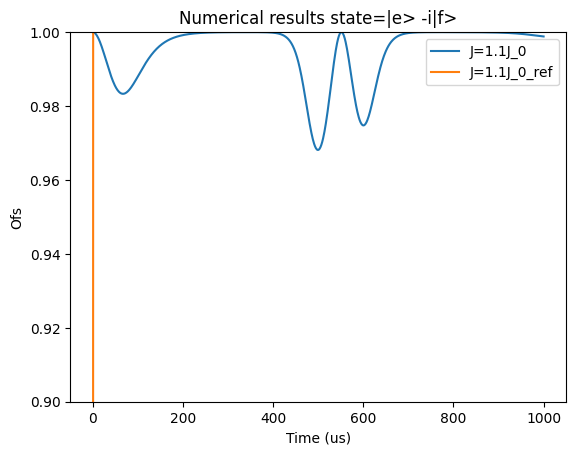

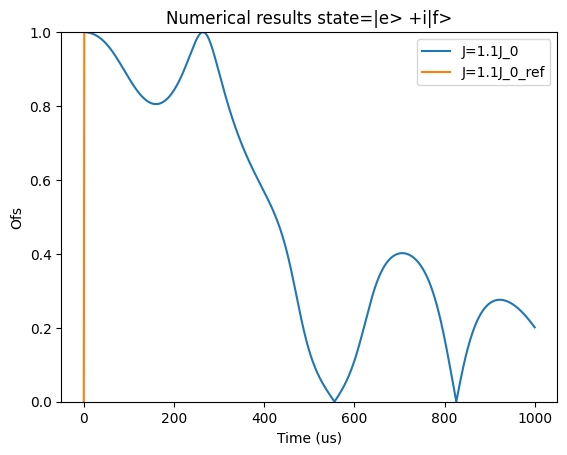

In [141]:
time, ofs_J1_plus, ofs_J1_minus,ofs_ts_plus_ref, ofs_ts_minus_ref= get_ofs_sim(1.5)


plt.plot(abs(ofs_J1_plus),label="J=1.1J_0")
plt.plot(abs(ofs_ts_plus_ref),label="J=1.1J_0_ref")

plt.legend()
plt.ylim(0.9,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Numerical results state=|e> -i|f>")
plt.show()
# plt.legend()
plt.plot(abs(ofs_J1_minus),label="J=1.1J_0")
plt.plot(abs(ofs_ts_minus_ref),label="J=1.1J_0_ref")

plt.legend()
plt.ylim(0,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Numerical results state=|e> +i|f>")
plt.show()



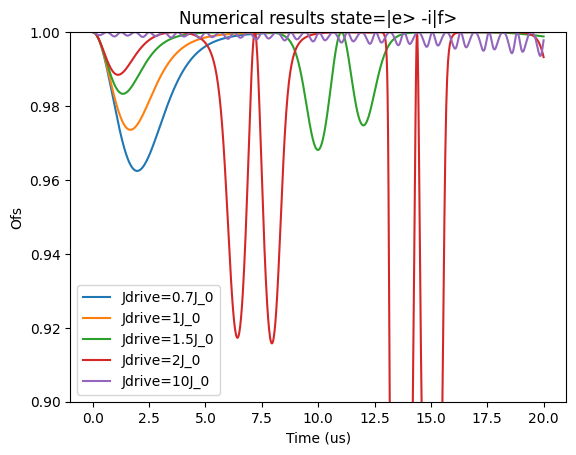

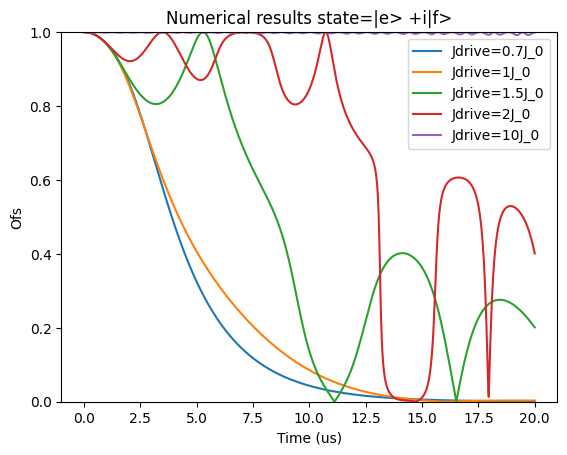

In [173]:

times=np.linspace(0,20,1001)
# plt.xlim(0,8)
r_list=[0.7,1,1.5,2,10]
for i in r_list:
    time, ofs_plus, ofs_minus,idx_plus,idx_minus= get_ofs_sim(i)
    plt.plot(times[idx_plus],abs(ofs_plus),label=f"Jdrive={i:.3g}J_0")

# plt.xlim(0,8)
plt.legend()
plt.ylim(0.9,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Numerical results state=|e> -i|f>")
plt.show()

for i in r_list:
    time, ofs_plus, ofs_minus,_,_= get_ofs_sim(i)
    plt.plot(times[idx_minus],abs(ofs_minus),label=f"Jdrive={i:.3g}J_0")

# plt.xlim(0,8)
plt.legend()
plt.ylim(0,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("Numerical results state=|e> +i|f>")
plt.show()








